# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Instrucciones del proyecto

1. Carga los datos.
2. Preprocesa los datos, si es necesario.
3. Realiza un análisis exploratorio de datos y haz tu conclusión sobre el desequilibrio de clases.
4. Realiza el preprocesamiento de datos para el modelado.
5. Entrena al menos tres modelos diferentes para el conjunto de datos de entrenamiento.
6. Prueba los modelos para el conjunto de datos de prueba.
7. Escribe algunas reseñas y clasifícalas con todos los modelos.
8. Busca las diferencias entre los resultados de las pruebas de los modelos en los dos puntos anteriores. Intenta explicarlas.
9. Muestra tus hallazgos.

¡Importante! Para tu comodidad, la plantilla del proyecto ya contiene algunos fragmentos de código, así que puedes usarlos si lo deseas. Si deseas hacer borrón y cuenta nueva, simplemente elimina todos esos fragmentos de código. Aquí está la lista de fragmentos de código:

- un poco de análisis exploratorio de datos con algunos gráficos;
- evaluate_model(): una rutina para evaluar un modelo de clasificación que se ajusta a la interfaz de predicción de scikit-learn;
- BERT_text_to_embeddings(): una ruta para convertir lista de textos en insertados con BERT.

Tu trabajo principal es construir y evaluar modelos.

Como puedes ver en la plantilla del proyecto, te sugerimos probar modelos de clasificación basados en regresión logística y potenciación del gradiente, pero puedes probar otros métodos. Puedes jugar con la estructura de la plantilla del proyecto siempre y cuando sigas sus instrucciones.

No tienes que usar BERT para el proyecto porque requiere mucha potencia computacional y será muy lento en la CPU para el conjunto de datos completo. Debido a esto, BERT generalmente debe ejecutarse en GPU para tener un rendimiento adecuado. Sin embargo, puedes intentar incluir BERT en el proyecto para una parte del conjunto de datos. Si deseas hacer esto, te sugerimos hacerlo de manera local y solo tomar un par de cientos de objetos por cada parte del conjunto de datos (entrenamiento/prueba) para evitar esperar demasiado tiempo. Asegúrate de indicar que estás usando BERT en la primera celda (el encabezado de tu proyecto).

### Descripción de los datos
Los datos se almacenan en el archivo imdb_reviews.tsv. Descargar el conjunto de datos. [https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv?etag=bbd4a8dc10e6cf1280c42d7350105c41]

Los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). **Learning Word Vectors for Sentiment Analysis**. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).

Aquí se describen los campos seleccionados:

- review: el texto de la reseña
- pos: el objetivo, '0' para negativo y '1' para positivo
- ds_part: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

Hay otros campos en el conjunto de datos, puedes explorarlos si lo deseas.

### Evaluación de proyecto
Hemos recopilado los criterios de evaluación para el proyecto. Léelos con atención antes de pasar al ejercicio:

- Cargaste y preprocesaste los datos de texto para su vectorización.
- Transformaste los datos de texto en vectores.
- Definiste, entrenaste y probaste los modelos.
- Se alcanzó el umbral de la métrica.
- Colocaste todas las celdas de código en el orden de su ejecución.
- Puedes ejecutar sin errores todas las celdas de código.
- Sacaste conclusiones.

Nuestros revisores también observarán la calidad general de tu proyecto:

- ¿Mantuviste la estructura del proyecto?
- ¿Mantuviste limpio tu código?
- ¿Conseguiste evitar la duplicación del código?
- ¿Cuáles fueron tus hallazgos?

## Inicialización

In [83]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

from lightgbm import LGBMClassifier
from tqdm.auto import tqdm
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [10]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [16]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.head(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [17]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

La columna votes y average_rating tienen 2 valores nulos. Descartaremos estos dos valores debido a que son muy pocos.  
end_year, runtime_minutes deberian ser ints como tipo de valor. La columna end_year adicionalmente usa //N como nan, remplazaremos esos por nans.

In [19]:
df_reviews = df_reviews.dropna()

In [25]:
df_reviews["end_year"]=df_reviews["end_year"].replace("\\N", np.nan).astype(float)
df_reviews["runtime_minutes"] = df_reviews["runtime_minutes"].replace("\\N", np.nan).astype(float)

Ahora veamos si tenemos desbalance en nuestro target.

pos
0    23715
1    23614
Name: count, dtype: int64


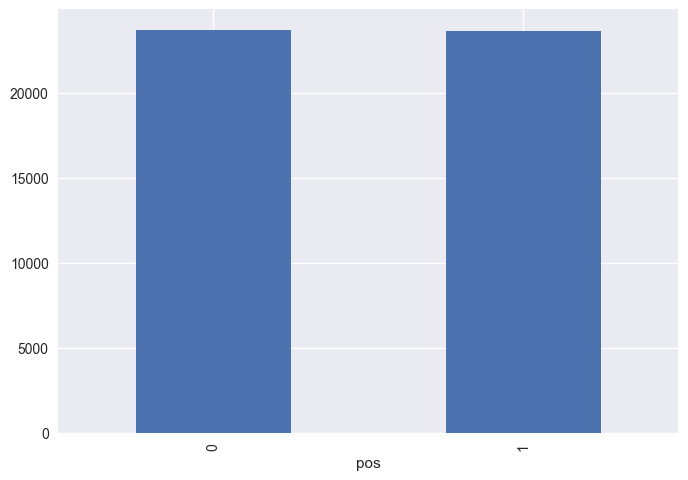

In [26]:
df_reviews['pos'].value_counts().plot(kind='bar')
print(df_reviews['pos'].value_counts())

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

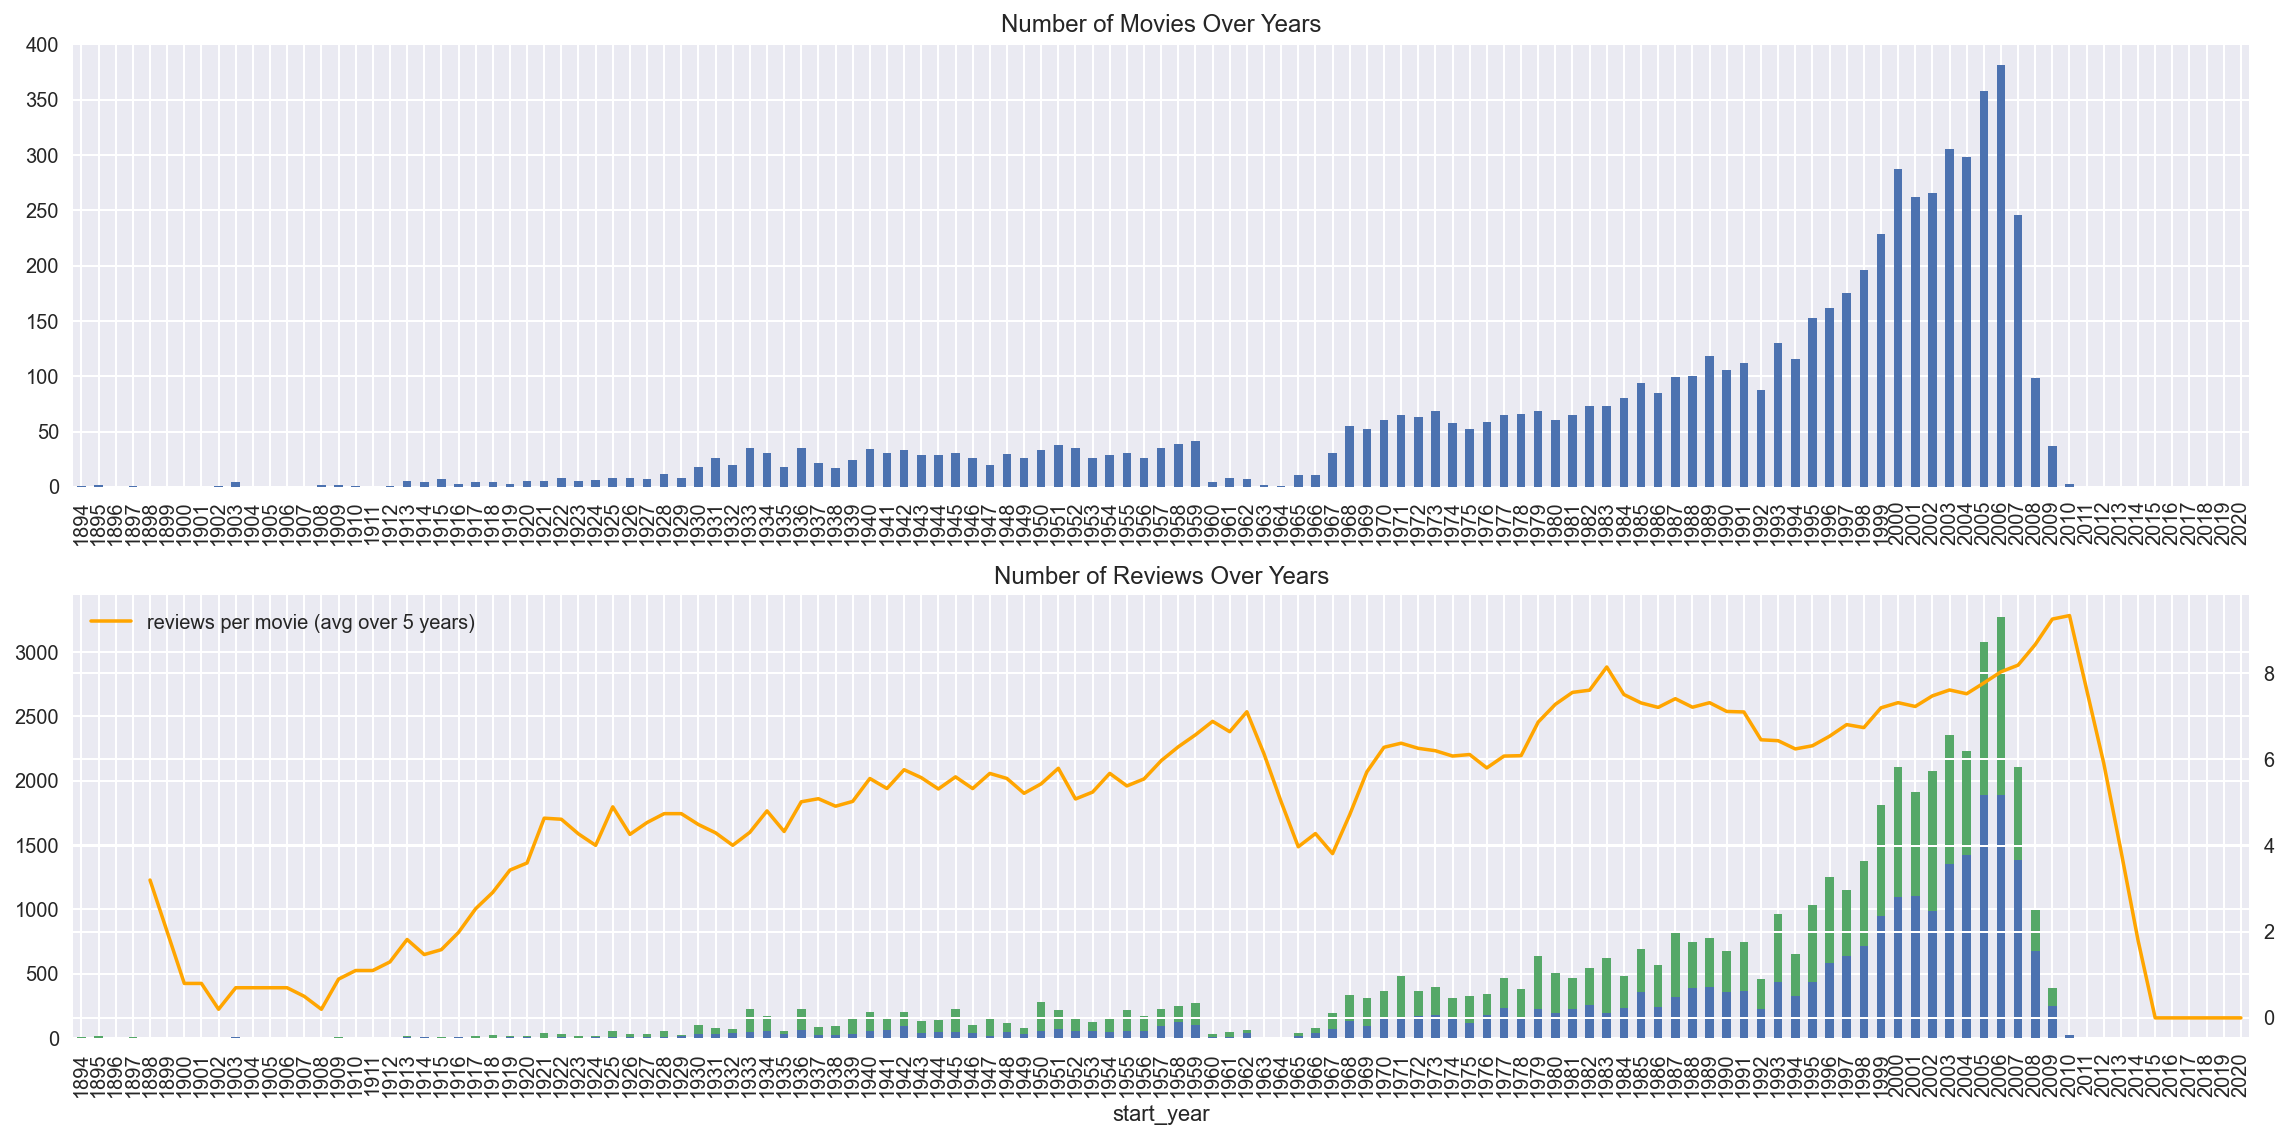

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Aqui podemos observar claramente que:

- El numero de peliculas aumenta cada año.
- Las reseñas por pelicula no aumentan de la misma forma en la que lo hacen las peliculas.
- Quiza nos pueda faltar informacion ya que la bajada despues del 2009 es muy abrupta, practicamente se va a 0 en un lapso de 4 años.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

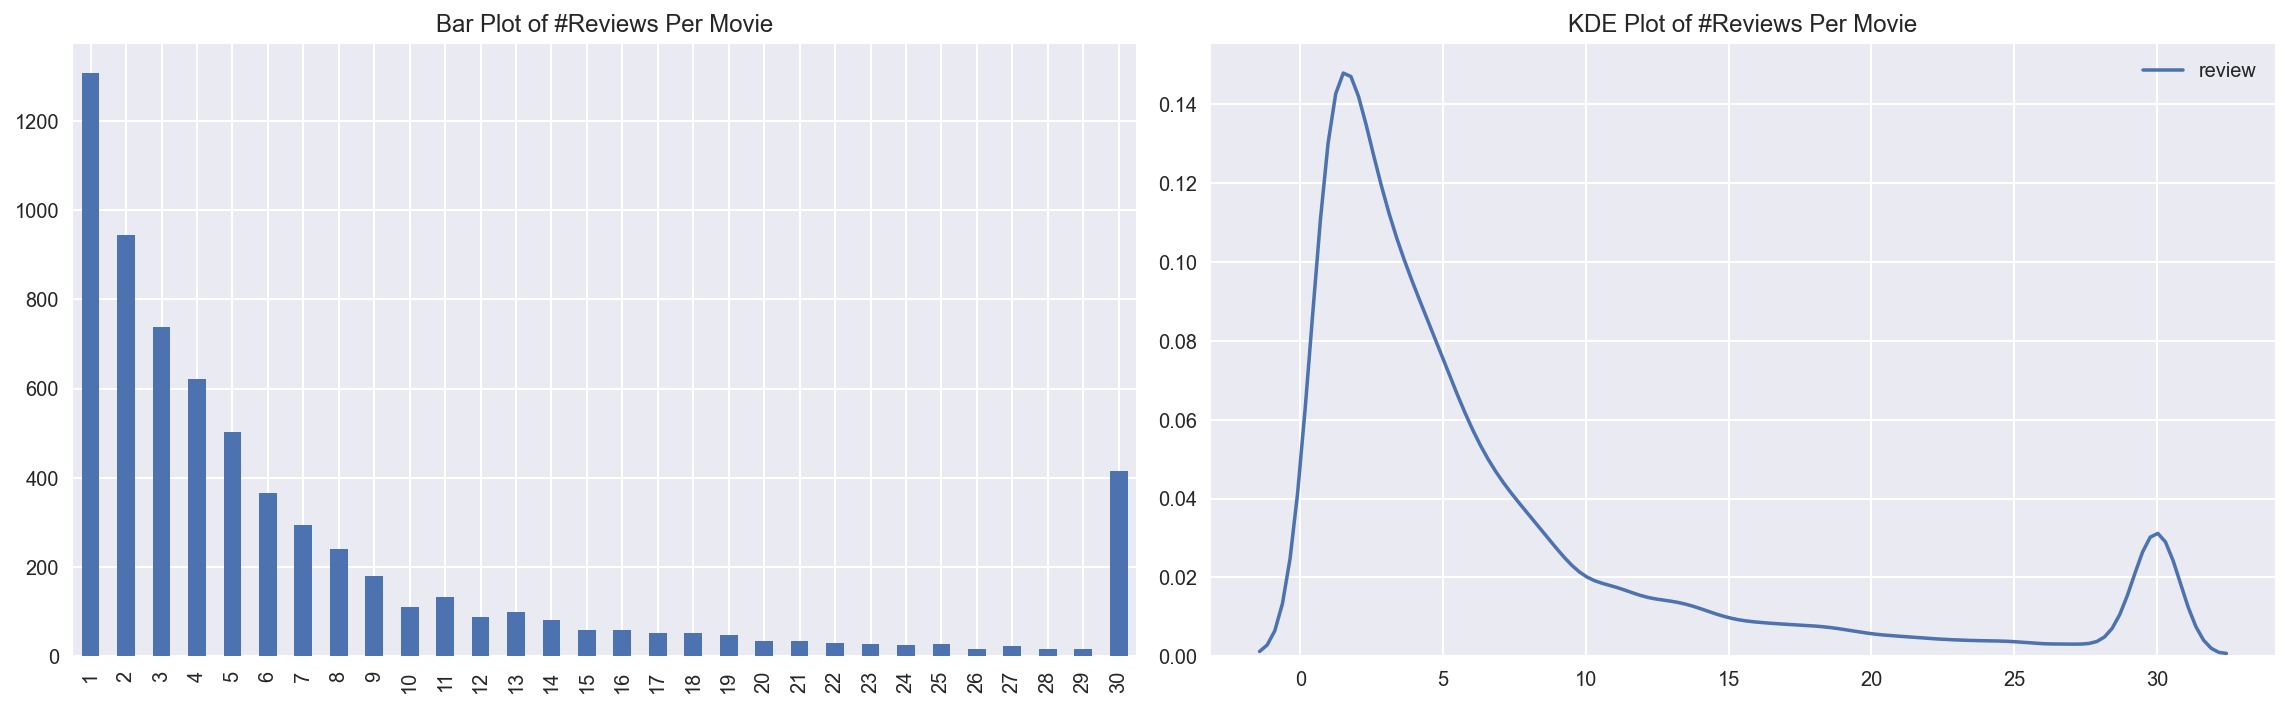

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [ ]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

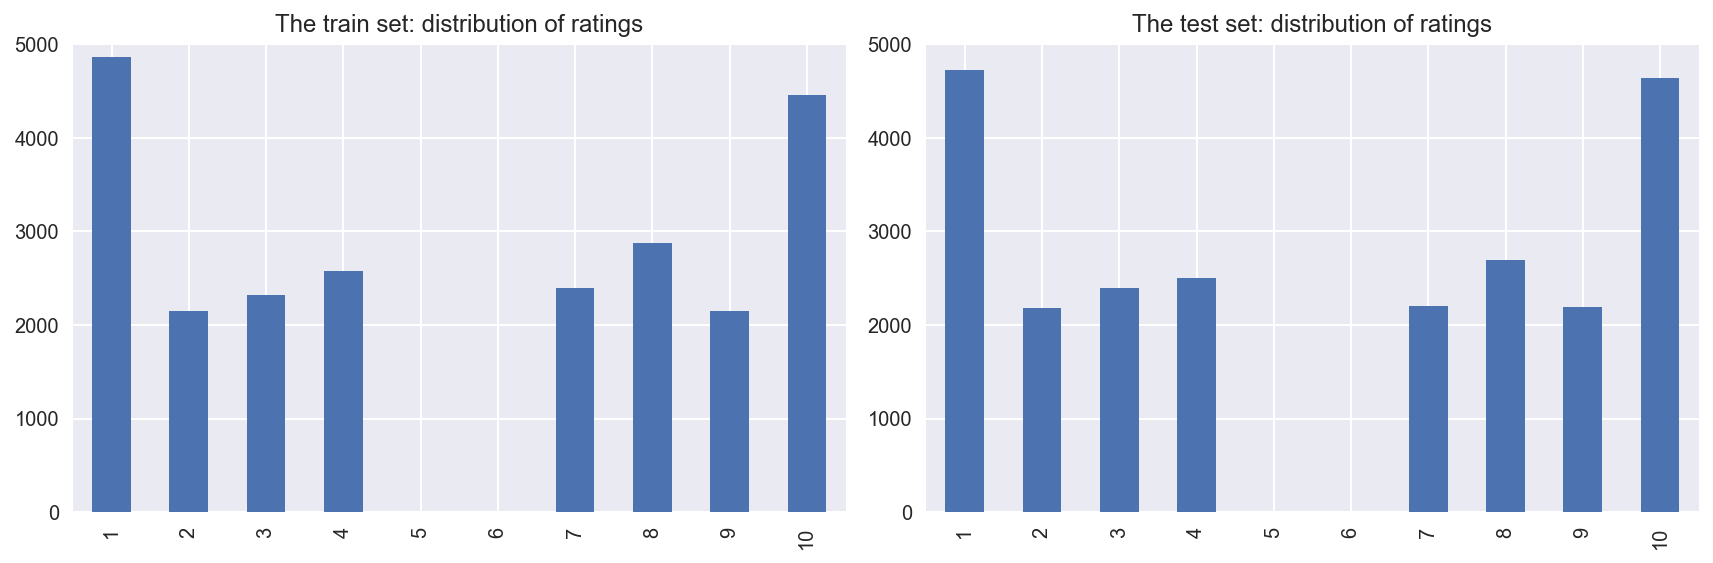

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Tanto el conjunto de entrenamiento como el de prueba estan polarizados, pero asu vez su distribución es muy similar.

### Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

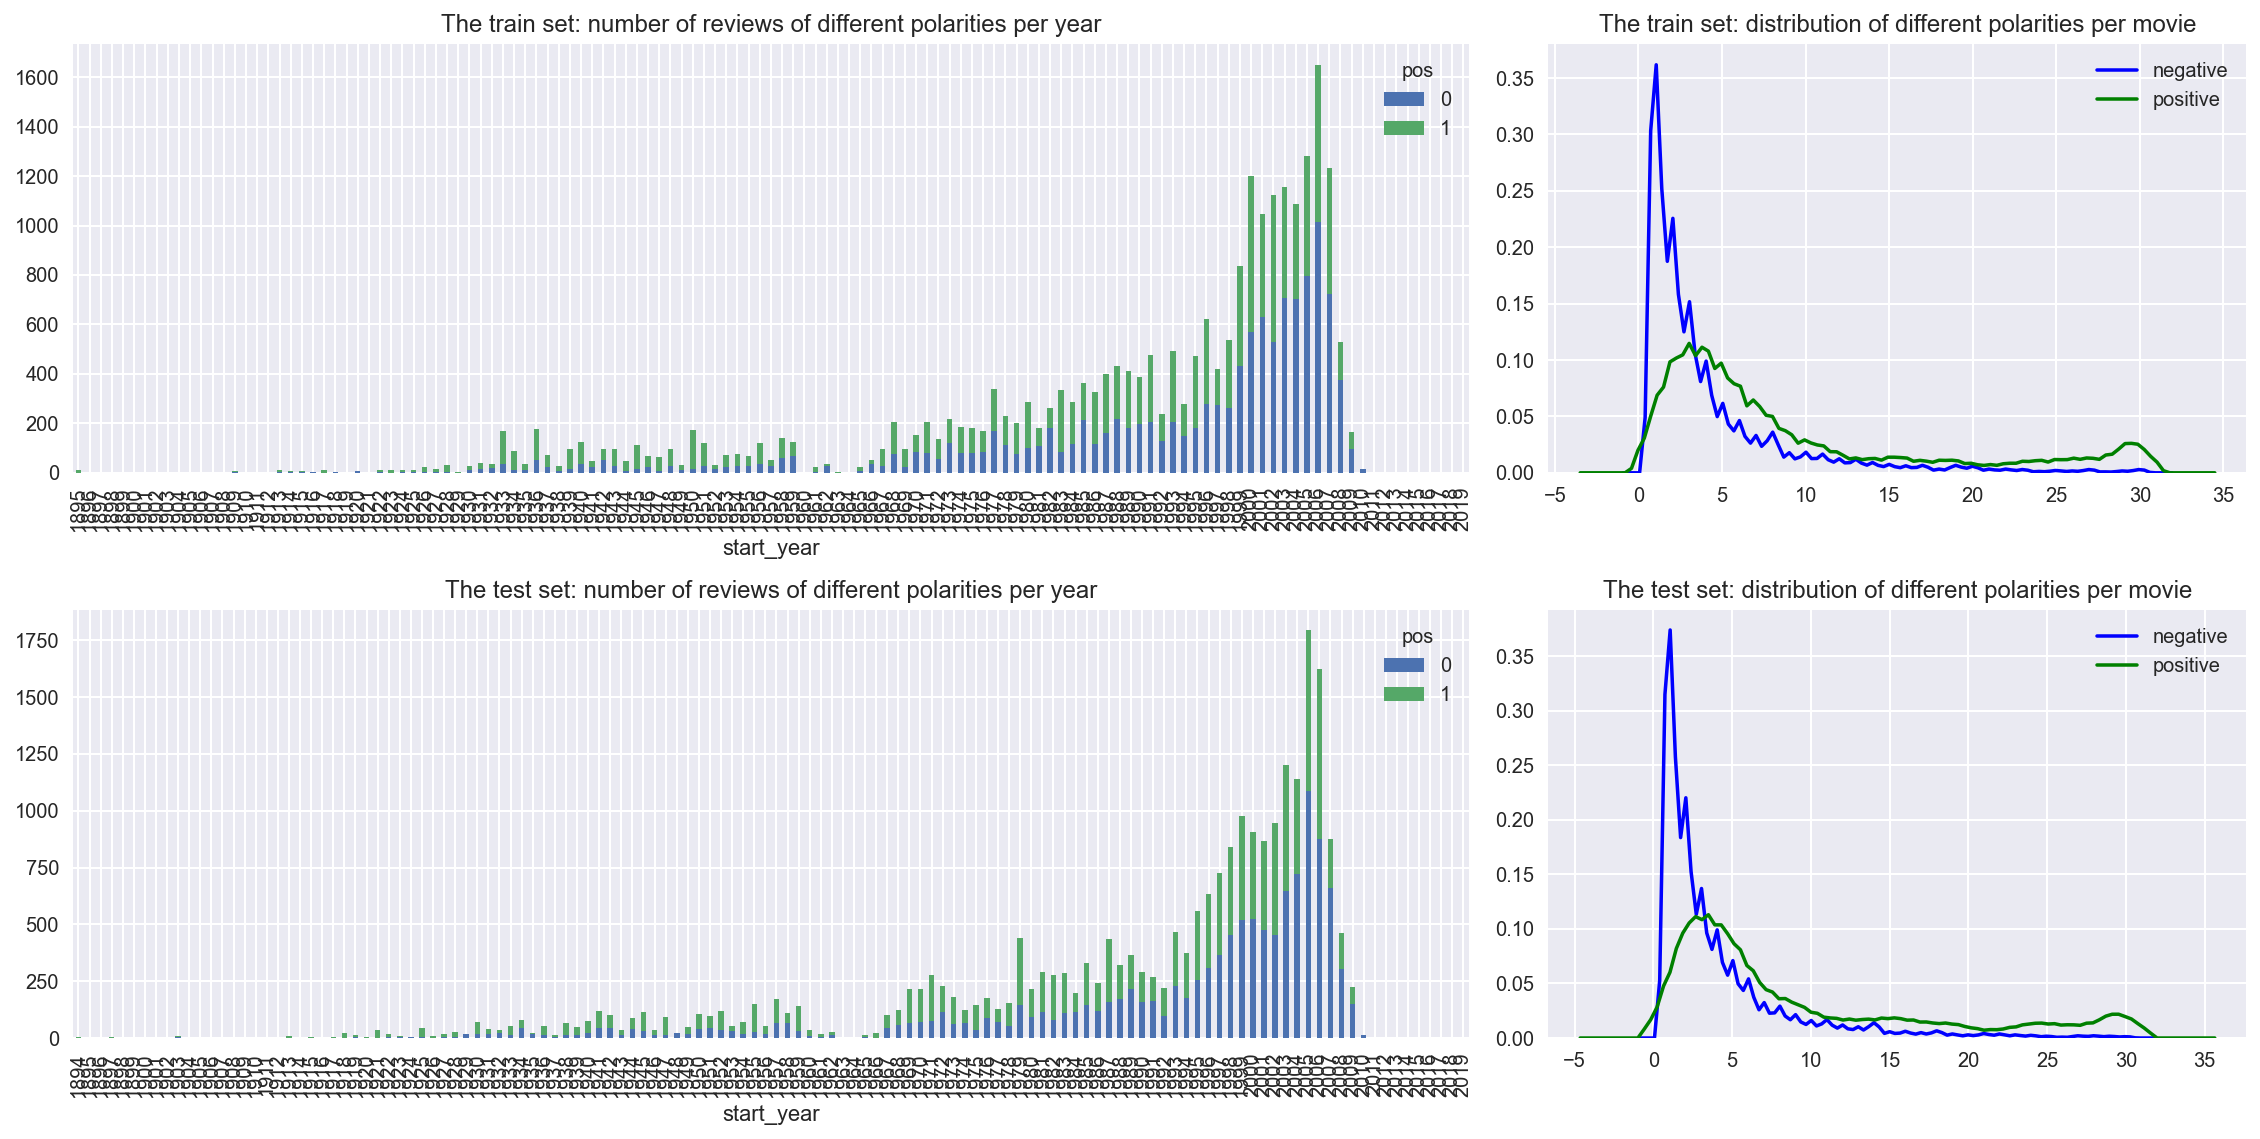

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Observaciones:
- La distribucion de reseñas tanto negativas como positivas es similar en ambos conjuntos de datos.
- En ambos conjuntos, muy pocas peliculas con reseñas negativas llegan a tener mas de 5 reseñas. Baja muchisimo despues de 1-2 reseñas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [27]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [ ]:
# df_reviews['review_norm'] = ...# <escribe tu código aquí>

Funcion para realizar esto con Spacy y NLTK

In [35]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])
                 #disable=['parser', 'ner'])

In [36]:
def limpia_texto_spacy(text):
    text = re.sub(r'[^\w\s]|\d+', '', text.lower())

    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop]
    
    return " ".join(lemmas)

In [39]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def limpia_texto_NLTK(text):
    text = re.sub(r'[^\w\s]|[\d+]', '', text.lower())

    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return " ".join(lemmas)

In [42]:
df_reviews['review_norm_spacy'] = df_reviews['review'].progress_apply(limpia_texto_spacy)

100%|██████████| 47329/47329 [12:39<00:00, 62.29it/s] 


In [45]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carlosvallejo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/carlosvallejo/nltk_data...


True

In [47]:
df_reviews['review_norm_NLTK'] = df_reviews['review'].progress_apply(limpia_texto_NLTK)

100%|██████████| 47329/47329 [00:36<00:00, 1280.55it/s]


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [48]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23533, 19)


In [61]:
spacy_nltk = ['review_norm_NLTK','review_norm_spacy']
train_features = df_reviews_train[spacy_nltk]
test_features = df_reviews_test[spacy_nltk]

## Trabajar con modelos

### Modelo 0 - Constante

In [54]:
from sklearn.dummy import DummyClassifier

Se crea un modelo DummyClassifier que asigne de forma estratificada, despues lo entrenaremos y evaluaremos

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


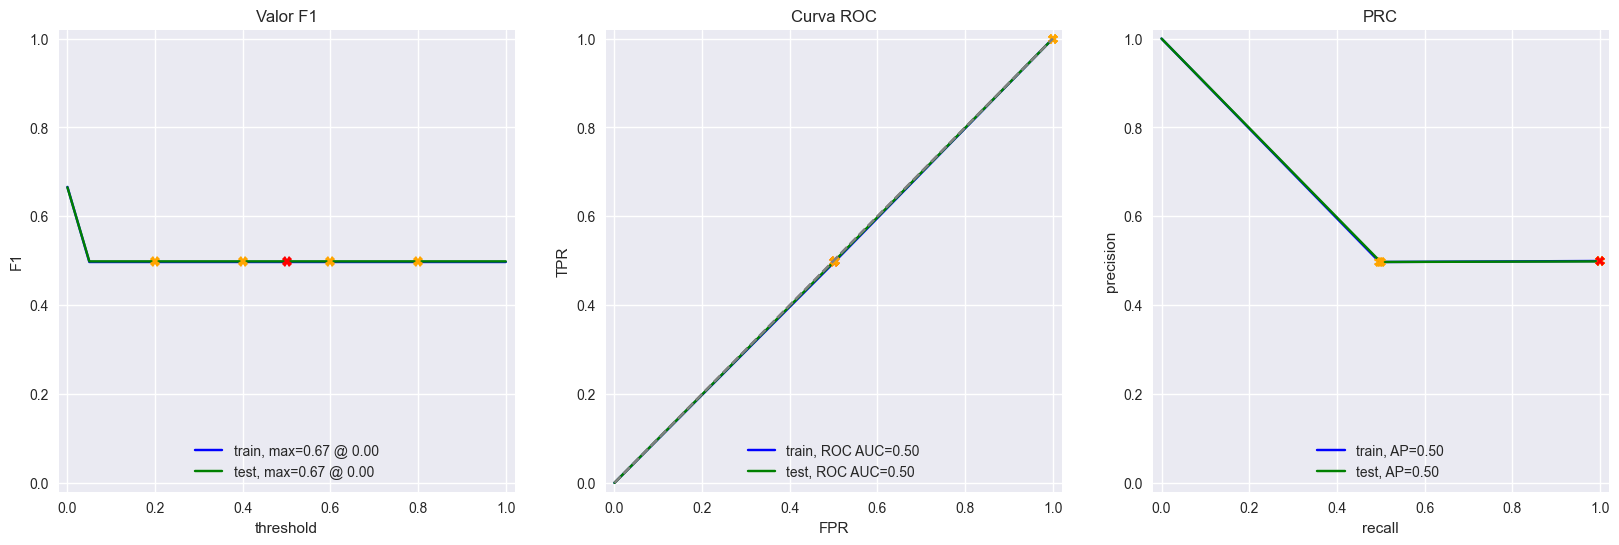

In [64]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(train_features["review_norm_NLTK"], train_target)
eval_0=evaluate_model(dummy_clf, train_features, train_target, test_features, test_target)

Este modelo no cumple con la meta que tenemos de un F1 > 0.85, en pocas palabras solamente nos sirve como un dummy o bien yuna prueba de cordura para los demas modelos.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [65]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [106]:
tf_idf_1 = TfidfVectorizer(stop_words="english")

In [107]:
train_features_1 = tf_idf_1.fit_transform(train_features["review_norm_NLTK"])
test_features_1 = tf_idf_1.transform(test_features["review_norm_NLTK"])
print('El tamaño de la matriz TF-IDF:', train_features_1.shape)

El tamaño de la matriz TF-IDF: (23796, 96960)


Entrenamos un modelo de regresión logistica.

In [73]:
model_1 = LogisticRegression(solver='liblinear')
model_1.fit(train_features_1, train_target)

LogisticRegression(solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95


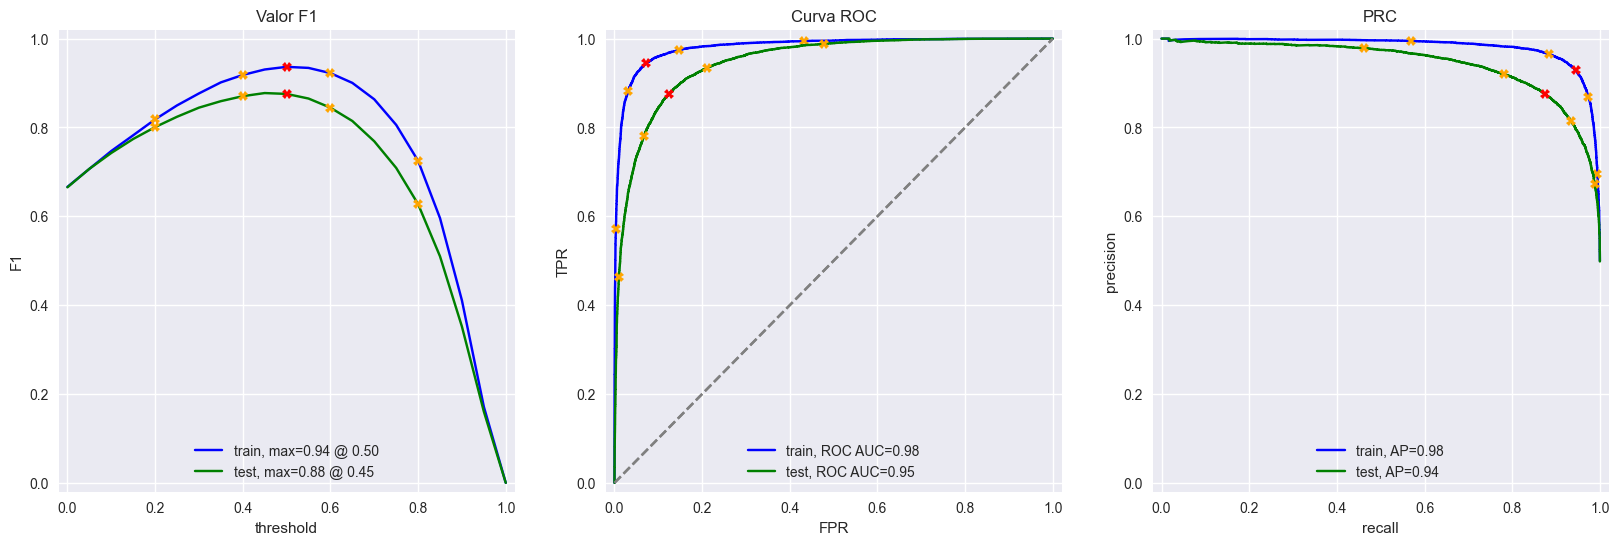

In [74]:
eval_1 = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Tuvimos un rendimiento aceptable con un F1 de 0.88 en el set de test.

### Modelo 3 - spaCy, TF-IDF y LR

Utilizaremos spacy, tfid y regresion logistica.

In [ ]:
#!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [33]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
'''
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)
'''

In [108]:
tf_idf_3 = TfidfVectorizer(stop_words="english")
train_features_3 = tf_idf_3.fit_transform(train_features["review_norm_spacy"])
test_features_3 = tf_idf_3.transform(test_features["review_norm_spacy"])
print('El tamaño de la matriz TF-IDF:', train_features_2.shape)

El tamaño de la matriz TF-IDF: (23796, 91026)


In [109]:
model_3 = LogisticRegression(solver='liblinear')
model_3.fit(train_features_3, train_target)

LogisticRegression(solver='liblinear')

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.94


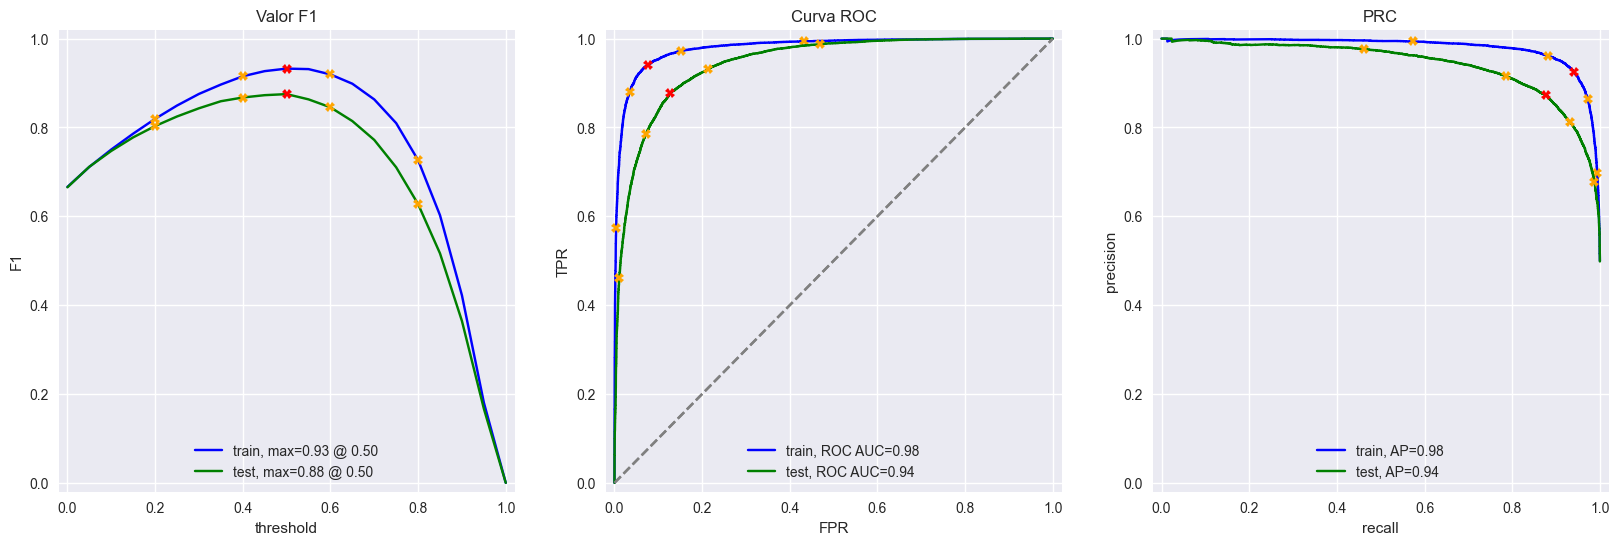

In [110]:
eval_3=evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Rendimiento **aceptable** de F1 de 0.88 en el set de test.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [84]:
param_dist  = {
    'n_estimators': randint(50, 250),
    'learning_rate': uniform(loc=0.01, scale=0.29), 
    'max_depth' : randint(2,9)}

In [ ]:
model_4 = LGBMClassifier(random_state=12345, verbose=-1)

random_search = RandomizedSearchCV(
    estimator=model_4, 
    param_distributions=param_dist, 
    cv= 4, 
    n_jobs=-1, 
    scoring='f1'
)

random_search.fit(train_features_3,train_target)

RandomizedSearchCV(cv=4,
                   estimator=LGBMClassifier(random_state=12345, verbose=-1),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x357e41810>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x357e417b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x357e42bf0>},
                   scoring='f1')

In [ ]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
print("Mejor score:", random_search.best_score_)
model_4_best = LGBMClassifier(**best_params)
model_4_best.fit(train_features_3, train_target)

Mejores hiperparámetros: {'learning_rate': 0.27888194642925473, 'max_depth': 5, 'n_estimators': 198}
Mejor score: 0.8464694983966388


LGBMClassifier(learning_rate=0.27888194642925473, max_depth=5, n_estimators=198)

          train  test
Accuracy   0.95  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


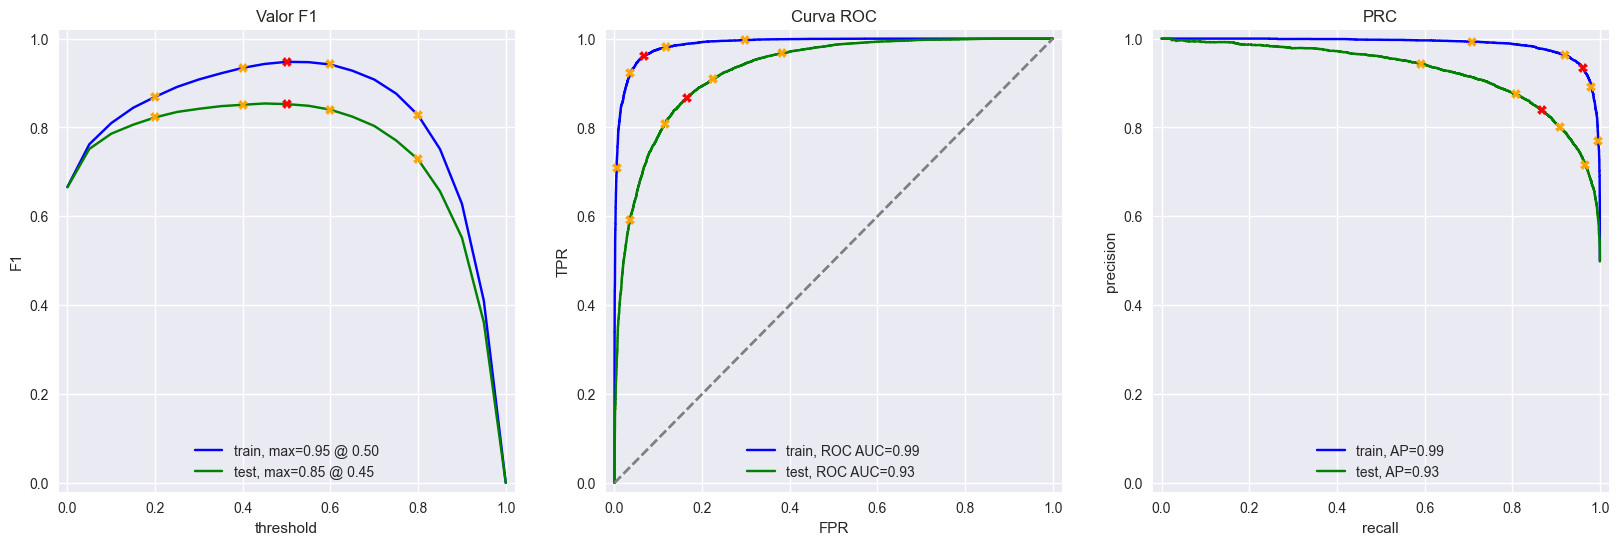

In [ ]:
eval_4=evaluate_model(model_4_best, train_features_3, train_target, test_features_3, test_target)

Este modelo nos da un resultado F1 de 0.864 en el set de test.

###  Modelo 9 - BERT

In [34]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención

    # <escribe tu código aquí para crear ids_list y attention_mask_list>

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

### Observaciones

Mis dos modelos de regresion logistica, aun siendo mas simples que el modelo que usaba lightGBM me dieron un mejor resultado yusando el F1 como parametro.

## Mis reseñas

In [111]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

#my_reviews['review_norm'] = ...# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews['review_norm_spacy'] = my_reviews['review'].progress_apply(limpia_texto_spacy)
my_reviews['review_norm_NLTK'] = my_reviews['review'].progress_apply(limpia_texto_NLTK)

my_reviews

100%|██████████| 8/8 [00:00<00:00, 6914.16it/s]


,review,review_norm_spacy,review_norm_NLTK
0,"I did not simply like it, not my kind of movie.",simply like kind movie,simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",bored feel asleep middle movie,well bored felt asleep middle movie
2,I was really fascinated with the movie,fascinate movie,really fascinated movie
3,Even the actors looked really old and disinter...,actor look old disinterested get pay movie sou...,even actor looked really old disinterested got...
4,I didn't expect the reboot to be so good! Writ...,not expect reboot good writer care source mate...,didnt expect reboot good writer really cared s...
5,"The movie had its upsides and downsides, but I...",movie upside downside feel like overall decent...,movie upside downside feel like overall decent...
6,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke land act ann...,rotten attempt comedy single joke land everyon...
7,Launching on Netflix was a brave move & I real...,launch netflix brave appreciate able binge e...,launching netflix brave move really appreciate...


### Modelo 2

In [113]:
texts = my_reviews['review_norm_NLTK']

my_reviews_pred_prob = model_1.predict_proba(tf_idf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  simply like kind movie
0.07:  well bored felt asleep middle movie
0.57:  really fascinated movie
0.16:  even actor looked really old disinterested got paid movie soulless cash grab
0.20:  didnt expect reboot good writer really cared source material
0.44:  movie upside downside feel like overall decent flick could see going see
0.03:  rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.90:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Modelo 3

In [117]:
texts = my_reviews['review_norm_spacy']

my_reviews_pred_prob = model_3.predict_proba(tf_idf_3.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  simply like kind movie
0.09:  bored feel asleep middle movie
0.64:  fascinate movie
0.18:  actor look old disinterested get pay movie soulless cash grab
0.23:  not expect reboot good writer care source material
0.44:  movie upside downside feel like overall decent flick go
0.02:  rotten attempt comedy single joke land act annoying loud kid will not like
0.91:  launch netflix brave   appreciate able binge episode episode exciting intelligent new drama


### Modelo 4

In [120]:
texts = my_reviews['review_norm_spacy']

tf_idf_4 = tf_idf_3
my_reviews_pred_prob = model_4_best.predict_proba(tf_idf_4.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  simply like kind movie
0.31:  bored feel asleep middle movie
0.59:  fascinate movie
0.47:  actor look old disinterested get pay movie soulless cash grab
0.54:  not expect reboot good writer care source material
0.57:  movie upside downside feel like overall decent flick go
0.31:  rotten attempt comedy single joke land act annoying loud kid will not like
0.77:  launch netflix brave   appreciate able binge episode episode exciting intelligent new drama


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

En pocas lo que mas grabado se me queda en este proyecto es que no necesariamente un modelo mas complejo da mejores resultados. 
Los modelos se aplicaron a nuevas reseñas y clasificaron correctamente estas reseñas.

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones